# Estimation of degradation of sensitivity induced by one baseline every 2 seconds rather than for every event 



This document contains a study required after our discussion of the document "R1 & DL0 Telescope Event Interfaces
and Prototype Evaluation" V0.1 from 06.02.2018  (I would put a link here, but as usual CTA avoids transparent version control in favor of secrecy and friction, so despite me having the document itself, I have absolutely no clue where it is hosted.)

We (i.e. the SST1M/Digicam analysis telcon) understand this document especially chapter "3.1 R1.TEL.EVT data model" in such a way, that every calibration step from R0 to R1 needs to be revertible. 

Part of our calibration is event-wise and pixel-wise baseline subtraction. We get one uint16 per event and pixel from the camera so we can subtract it. But we understand the document in such a way, that we must not apply this calibration, because we are not allowed to store these calibration constants, and since we must not store them, we cannot revert this calibration step. 

While we get the baseline for every pixel with every event, we could alternatively ignore almost all of these event-wise baselines and instead use one value for all events within a certain time window, e.g. 2sec and thus reduce the performance of the calibration.

We are not sure about the impact of this on sensitivity. This study tries to give a hint ... it cannot fully answer this question, since for a complete study of the sensitivity we'd need monte carlos, which I think do not exist yet.

### Dataset

I have access to the Crab Dataset from Nov 2017 taken in Kraków and will try to assess the impact of a reduced baseline sampling frequency on the estimated hillas parameters and on the event rate after cuts. 

The zfits files I have downloaded with a shell script named "download_crab_2017_10_30.sh" provided by Etienne. No aux-files are needed for this study.

### Reproducability:


This study is fully contained in this single ipython-notebook. So you should be able to download it and repeat this study (rather quickyly).

This notebook expects the fits.fz files in this the place pointed to by the variable `raw_file_path`. Please adjust this to your local setup.

In this notebook I only execute/call analysis functions, I do not implement them here. Since for this study I needed to make some variations from the current digicampipe master, I created a branch for this study.

https://github.com/cta-sst-1m/digicampipe/tree/crab_analysis_study_dneise

So ... to reproduce this study, you'll have to downloand and install this particular branch. 
For the digicampipe developers this means, independend of the question if this branch is ever merged or not, it must never be deleted, since the reproducability of this study depends on it.

This is a nuisance ... a better solution would be to base all studies only on released versions of digigcampipe. github takes care of storing all releases forever (more or less)...

### What's this `if not os.path.isfile` stuff about?

Since I am often playing around in the lower parts of this study, I did not want to re-process all the previous parts all the time. So when ever I had the feeling that a certain part is done, I wrote an output file. 
In case a file of this name already existed, the code would simply not re-analyse everything again.

So in case you would like to do the plots ... but not wait for the analysis to finish. just ask me for the files ... they are only few MB .. I can send them to you. (not sure I can publish them on githib though).

Also, I only use the runs starting at 019, the files before never contained any event after cuts.

In [1]:
raw_file_path = '../data'

import os, os.path
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from digicampipe.io.event_stream import event_stream
from digicampipe.utils import histogram
from digicampipe.io.zfits import ZFile

from glob import glob
from tqdm import tqdm

from digicampipe.scripts.baseline import main as save_dark_baseline
from digicampipe.scripts.pipeline_crab import main as pipeline_crab
from digicampipe.scripts.pipeline_crab_using_digicam_baseline import main as pipeline_crab_using_digicam_baseline
from digicampipe.scripts.pipeline_crab_using_digicam_baseline_only_every_2_sec import main as pipeline_crab_using_digicam_baseline_only_every_2_sec


/home/dneise/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
if not os.path.isfile('./dark_baseline.npz'):
    save_dark_baseline(
        baseline_file_path='./dark_baseline.npz',
        files=[os.path.join(raw_file_path, 'SST1M01_20171030.002.fits.fz')]
    )

In [3]:
paths = []
for path in sorted(glob(raw_file_path + '/*.fits.fz')):
    run_id = int(path[-11:-8])
    if run_id >= 19:
        paths.append(path)
len(paths)

73

In [4]:
def perform_analysis(
    analysis,
    paths,
    output_directory,
    baseline_path='./dark_baseline.npz',
):
    os.makedirs(output_directory, exist_ok=True)
    for path in paths:
        basename = os.path.split(path)[1]
        basename_no_ext = basename[:-8]
        run_id = int(basename_no_ext[-3:])
        outfile_name = os.path.join(
            output_directory,
            basename_no_ext + '.jsonl'
        )
        if not os.path.isfile(outfile_name):
            hillas_parameters = pd.DataFrame(
                pipeline_crab(
                    files=[path],
                    baseline_path=baseline_path,
                )
            )
            hillas_parameters['run_id'] = run_id
            hillas_parameters.to_json(
                outfile_name, 
                lines=True, 
                orient='records'
            )


In [5]:
perform_analysis(
    analysis=pipeline_crab,
    paths=paths,
    output_directory='hillas_parameters_according_to_std_pipeline_crab'
)

In [6]:
perform_analysis(
    analysis=pipeline_crab_using_digicam_baseline,
    paths=paths,
    output_directory='hillas_parameters_using_digicam_baseline'
)

In [7]:
perform_analysis(
    analysis=pipeline_crab_using_digicam_baseline_only_every_2_sec,
    paths=paths,
    output_directory='hillas_parameters_using_digicam_baseline_only_every_2_sec'
)

/home/dneise/sst/ctapipe/ctapipe/image/hillas.py:582: RuntimeWarning: invalid value encountered in sqrt
  width = np.sqrt((vy2 + vx2 - z) / 2.0)
/home/dneise/sst/digicampipe/digicampipe/calib/camera/dl1.py:122: RuntimeWarning: invalid value encountered in sqrt
  dl1_camera.time_spread = np.sqrt(dl1_camera.time_spread)


### Analysis is done ... looking at results

In [8]:
std_pipeline = pd.concat([
    pd.read_json(path, lines=True) 
    for path in glob('hillas_parameters_according_to_std_pipeline_crab/*.jsonl')])
using_digicam = pd.concat([
    pd.read_json(path, lines=True) 
    for path in glob('hillas_parameters_using_digicam_baseline/*.jsonl')])
only_every_2_sec = pd.concat([
    pd.read_json(path, lines=True) 
    for path in glob('hillas_parameters_using_digicam_baseline_only_every_2_sec/*.jsonl')])

In [13]:
len(std_pipeline), len(using_digicam), len(only_every_2_sec)

(56686, 56513, 56686)

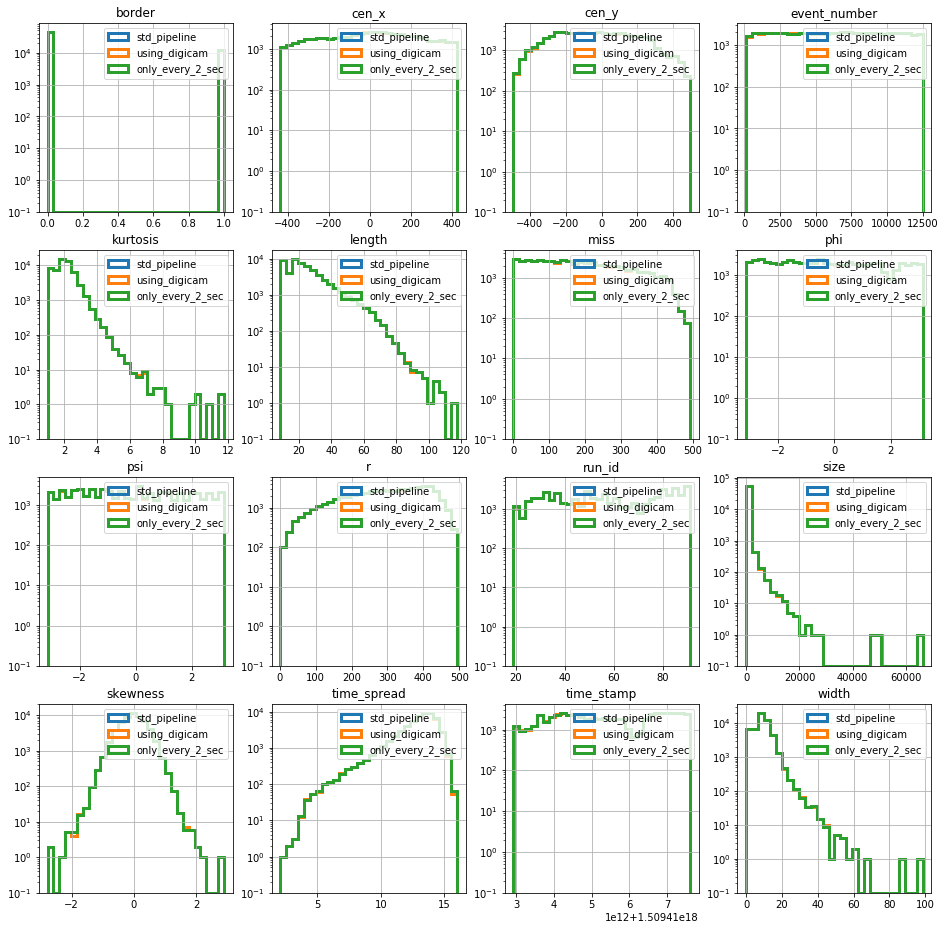

In [9]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i, name in enumerate(std_pipeline.columns):
    ax=axes.flatten()[i]
    std_pipeline[name].hist(bins=30, log=True, lw=3, histtype='step', ax=ax, label='std_pipeline')
    using_digicam[name].hist(bins=30, log=True, lw=3, histtype='step', ax=ax, label='using_digicam')
    only_every_2_sec[name].hist(bins=30, log=True, lw=3, histtype='step', ax=ax, label='only_every_2_sec')
    ax.set_title(name)
    ax.legend()
    

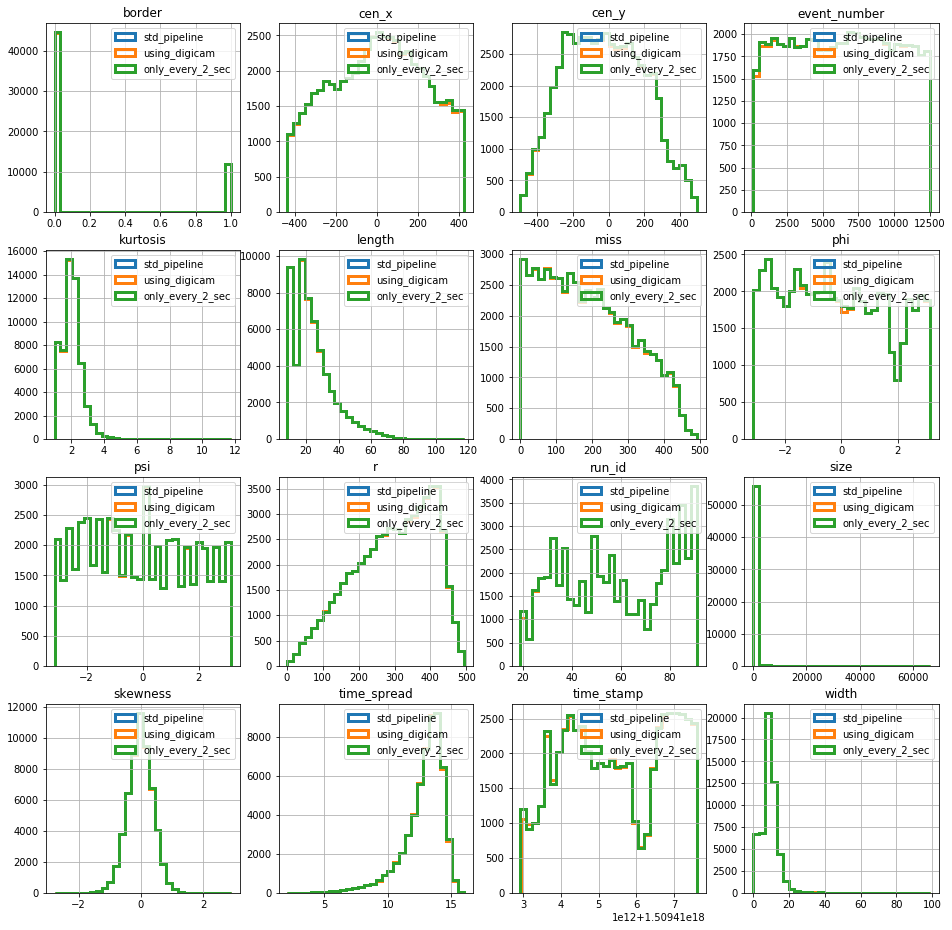

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i, name in enumerate(std_pipeline.columns):
    ax=axes.flatten()[i]
    std_pipeline[name].hist(bins=30, lw=3, histtype='step', ax=ax, label='std_pipeline')
    using_digicam[name].hist(bins=30, lw=3, histtype='step', ax=ax, label='using_digicam')
    only_every_2_sec[name].hist(bins=30, lw=3, histtype='step', ax=ax, label='only_every_2_sec')
    ax.set_title(name)
    ax.legend()
    